<a href="https://colab.research.google.com/github/123nishant/Google-Colab/blob/master/One_Pipeline_Many_Classifiers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Text Classification with Naive Bayes, Logistic Regression, SVM

Gives a brief overview of performing text Classification using Naive Bayes, Logistic Regression and SVMs. 

***Goal of this notebook : ***
Explore process of training and testing text classifiers for this problem, using this data set and 2 text classification algorithms : 

1.Multinomial Naive Bayes
2.Logistic Regression



In [1]:
from google.colab import files
uploaded = files.upload()

Saving Full-Economic-News-DFE-839861.csv to Full-Economic-News-DFE-839861.csv


In [3]:
import numpy as np
import pandas as pd # To work with csv files

#matplotlib imports are used to plot confusion matrices for the classifiers
import matplotlib as mpl
import matplotlib.cm as cm # Color Maps
import matplotlib.pyplot as plt

# Import feature extraction methods from sklearn
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction import stop_words

# Pre-processing of text
import string
import re

# import classifiers from sklearn
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC

# import different metrics to evaluate the classifiers
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn import metrics

# import time function from time module to track the training duration
from time import time

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.feature_extraction.stop_words module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_extraction.text. Anything that cannot be imported from sklearn.feature_extraction.text is now part of the private API.
  warnings.warn(message, FutureWarning)


Section 1 : Load and explore the dataset

In [3]:
!wget -P DATAPATH https://raw.githubusercontent.com/practical-nlp/practical-nlp/master/Ch4/Data/Full-Economic-News-DFE-839861.csv
!ls -lah DATAPATH

--2020-09-24 10:18:33--  https://raw.githubusercontent.com/practical-nlp/practical-nlp/master/Ch4/Data/Full-Economic-News-DFE-839861.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 12383529 (12M) [text/plain]
Saving to: ‘DATAPATH/Full-Economic-News-DFE-839861.csv’

Full-Economic-News- 100%[===================>]  11.81M  21.8MB/s    in 0.5s    

2020-09-24 10:18:34 (21.8 MB/s) - ‘DATAPATH/Full-Economic-News-DFE-839861.csv’ saved [12383529/12383529]

total 12M
drwxr-xr-x 2 root root 4.0K Sep 24 10:18 .
drwxr-xr-x 1 root root 4.0K Sep 24 10:18 ..
-rw-r--r-- 1 root root  12M Sep 24 10:18 Full-Economic-News-DFE-839861.csv


In [4]:
our_data = pd.read_csv("DATAPATH/Full-Economic-News-DFE-839861.csv", encoding="ISO-8859-1")

display(our_data.shape) # No. of rows (instances) and columns in the dataset
our_data["relevance"].value_counts()/our_data.shape[0] # Class distribution in the datase

(8000, 15)

no          0.821375
yes         0.177500
not sure    0.001125
Name: relevance, dtype: float64

Okay  ,the dataset is imbalanced

In [5]:
# Converting labels to a numerical variable
our_data = our_data[our_data.relevance != "not sure"]
our_data.shape
our_data['relevance'] = our_data.relevance.map({'yes':1, 'no':0}) # Relevant is 1, not-relevant is 0
our_data = our_data[["text", "relevance"]] # Let us take only 2 columns we need
our_data.shape

(7991, 2)

# Section 2 : Text Preprocessing

Typical steps involve : 


*   Tokenization
*   Lower casing

*   Removing stop words
*   Punctuation Markers


*   Vectorization
*   Stemming / Lemmatization 







In [6]:
stopwords = stop_words.ENGLISH_STOP_WORDS

def clean(doc):
  # doc is a string of text
  
  doc = doc.replace("</br>", " ") # This text contains a lot of <br/> tags/ Hence removing them
  doc = "".join([char for char in doc if char not in string.punctuation and not char.isdigit()])
  # Removing punctuation marks and digits
  doc = " ".join([token for token in doc.split() if token not in stopwords])
  # Removing stopwords

  return doc


# Section 3 : Modeling

We are going to use algorithms from sklearn package. 

Below steps are followed : 
1. Split data into training and test sets (75% train, 25% test)
2. Extract features from training data using CountVectorizer, which is a Bag of Words feature implementation. 
We will use pre-processing function above in conjunction with Count Vectorizer
3. Transform the test data into the same feature vector as the training data
4. Train the classifier 
5. Evaluate the classifier

In [7]:
import sklearn 
# from sklearn.cross_validation import train_test_split
from sklearn.model_selection import train_test_split

# Step 1 : train-test split
X = our_data.text # Column text contains textual data to extract features 
y = our_data.relevance # this is column we are learning to predict
print(X.shape, y.shape)
# Split X and y into training and testing sets. By default, it splits 75% training and 25% test 
# random_state = 1 for reproducibility
X_train , X_test, y_train, y_test = train_test_split(X, y, random_state = 1)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(7991,) (7991,)
(5993,) (5993,)
(1998,) (1998,)


In [8]:
# Step 2-3 : Preprocess and Vectorize train and test data
vect = CountVectorizer(preprocessor=clean) # instantiate a vectorizer
X_train_dtm = vect.fit_transform(X_train) # use it to extract features from trainng data

# transform testing data (using training data's features)
X_test_dtm = vect.transform(X_test)
print(X_train_dtm.shape, X_test_dtm.shape)
#i.e. , the dimension of our feature vector is 49753!

(5993, 49753) (1998, 49753)


In [9]:
# Step 3 : Train the classifier and predict for test data
nb = MultinomialNB() # Instantiate a Multinomial Naive Bayes Model
%time nb.fit(X_train_dtm, y_train) # train the model(timing it with an Ipython "magic command")
y_pred_class = nb.predict(X_test_dtm) # Make class predictions for X_test_dtm

# Wall time : Refers to real-world time. 
# Differs from time as measured by counting microprocessor clock pulses or cycles

CPU times: user 13.4 ms, sys: 34 µs, total: 13.5 ms
Wall time: 14.6 ms


Accuracy:  0.7822822822822822
ROC_AUC_Score: 0.7251117679464362


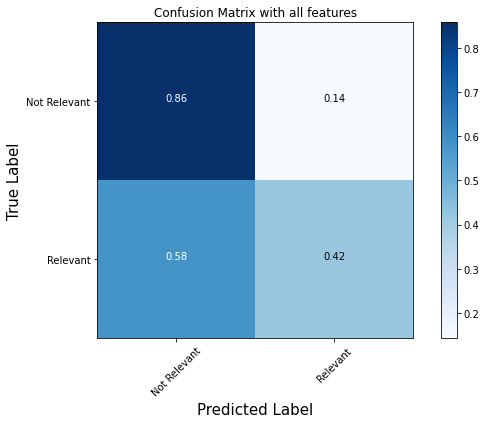

In [10]:
# Step 4 : Evaluate the classifier using various measures

# Function to plot confusion matrix

# Ref : http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap = plt.cm.Blues):
  """
  This function prints and plots the confusion matrix. 
  Normalization can be applied by setting 'normalization=True'.
  """

  if normalize :
    cm = cm.astype('float') / cm.sum(axis = 1)[:, np.newaxis]

  plt.imshow(cm, interpolation='nearest', cmap = cmap)
  plt.title(title)
  plt.colorbar()
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes, rotation = 45)
  plt.yticks(tick_marks, classes)

  fmt = '.2f' if normalize else 'd'
  thresh = cm.max() / 2.
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], fmt),
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")
    
    plt.tight_layout() # Automatically adjusts subplots to give specified padding
    plt.ylabel('True Label', fontsize=15)
    plt.xlabel('Predicted Label', fontsize=15)

# Print accuracy:
print("Accuracy: ",metrics.accuracy_score(y_test, y_pred_class))

# print confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred_class)
plt.figure(figsize=(8,6))
plot_confusion_matrix(cnf_matrix, classes = ['Not Relevant','Relevant'],
                      normalize=True, title='Confusion Matrix with all features')

# Calculate AUC : Area inder the Curve (AUC) gives idea about model efficiency
y_pred_prob = nb.predict_proba(X_test_dtm)[:,1]
print("ROC_AUC_Score:", metrics.roc_auc_score(y_test, y_pred_prob))

CPU times: user 5.59 ms, sys: 0 ns, total: 5.59 ms
Wall time: 5.6 ms
Accuracy: 0.6876876876876877


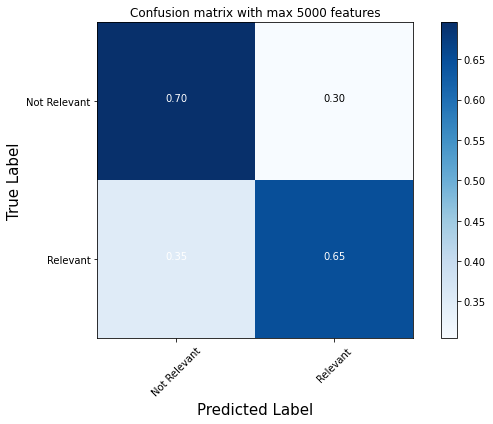

In [11]:
vect = CountVectorizer(preprocessor=clean, max_features=5000) # step 1
X_train_dtm = vect.fit_transform(X_train) # Combined step 2 and 3
X_test_dtm = vect.transform(X_test)

nb = MultinomialNB() # Instantiate a Multinomial Naive Bayes Model
%time nb.fit(X_train_dtm, y_train) # train model ( timing with Ipython magic command)

y_pred_class = nb.predict(X_test_dtm) # make class predictions for X_test_dtm
print("Accuracy:", metrics.accuracy_score(y_test, y_pred_class))

# print confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred_class)
plt.figure(figsize=(8, 6))
plot_confusion_matrix(cnf_matrix, classes=['Not Relevant', 'Relevant'], normalize=True,
                      title = 'Confusion matrix with max 5000 features')



Clearly, the performance on relevance classification got better even though the overall accuracy fell by 10%. Let us try another classification algorithm and see if the performance changes. For this experiment, we have considered **logistic regression, with class_weight attribute as "balanced", to address the problem of class imbalance in this dataset.**


In [12]:
#!pip install -U scikit-learn

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Accuracy: 0.7362362362362362
AUC: 0.7251117679464362


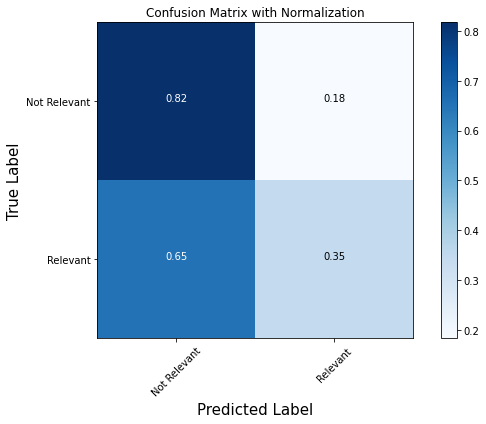

In [14]:
from sklearn.linear_model import LogisticRegression # import 

logreg = LogisticRegression(class_weight="balanced") # Instantiate  a logistic regression model

logreg.fit(X_train_dtm, y_train) # Fit the model with the training data

# Make predictions on test data
y_pred_class = logreg.predict(X_test_dtm)

# Calculate evaluation measures:
print("Accuracy:", metrics.accuracy_score(y_test, y_pred_class))

print("AUC:", metrics.roc_auc_score(y_test, y_pred_prob))
cnf_matrix = confusion_matrix(y_test, y_pred_class)
plt.figure(figsize=(8, 6))
plot_confusion_matrix(cnf_matrix, classes = ['Not Relevant', 'Relevant'], normalize = True,
                      title = 'Confusion Matrix with Normalization')


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Accuracy: 0.6861861861861862
AUC: 0.7251117679464362


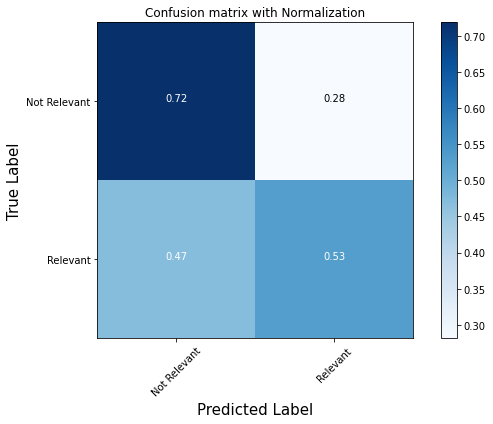

In [18]:
# Using on emore classifier 

from sklearn.svm import LinearSVC

vect = CountVectorizer(preprocessor = clean, max_features=1000) # Step 1
X_train_dtm = vect.fit_transform(X_train) # Combined step 2 and step 3
X_test_dtm = vect.transform(X_test)

classifier = LinearSVC(class_weight = 'balanced') # Instantiate a logistic regression model
classifier.fit(X_train_dtm, y_train) # Fit model with training data

# Make predictions on test data
y_pred_class = classifier.predict(X_test_dtm)

# Calculate evaluation measures:
print("Accuracy:", metrics.accuracy_score(y_test, y_pred_class))
print("AUC:", metrics.roc_auc_score(y_test, y_pred_prob))
cnf_matrix = confusion_matrix(y_test, y_pred_class)
plt.figure(figsize=(8, 6)) 
plot_confusion_matrix(cnf_matrix, classes=['Not Relevant', 'Relevant'], 
                      normalize=True, title = 'Confusion matrix with Normalization')

SO how do we chose the best ? 

If we look at overall accuracy alone ,  we should be choosing  1st classifier. 
However, that is also doing poorly in identifying "relevant" articles. 
If we choose purely on how good it is doing with "irrelevant" category, surely , nothing beats not building any classifier and just calling everything irrelevant. 

**It depends on what we are looking for in our USE-CASE , helps us identify the best classifier. ***